In [27]:
#Import library
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import torch



In [10]:
#Read data from file

#Read training data
DATA_PATH = os.path.join('..','data') # use '..' to go up one directory level
SOURCE = 'huggingface'
NAME = 'Final_Augmented_dataset_Diseases_and_Symptoms.csv'
training_data = pd.read_csv(os.path.join(DATA_PATH, SOURCE, NAME)).dropna(axis=1)


the number of disease: 773


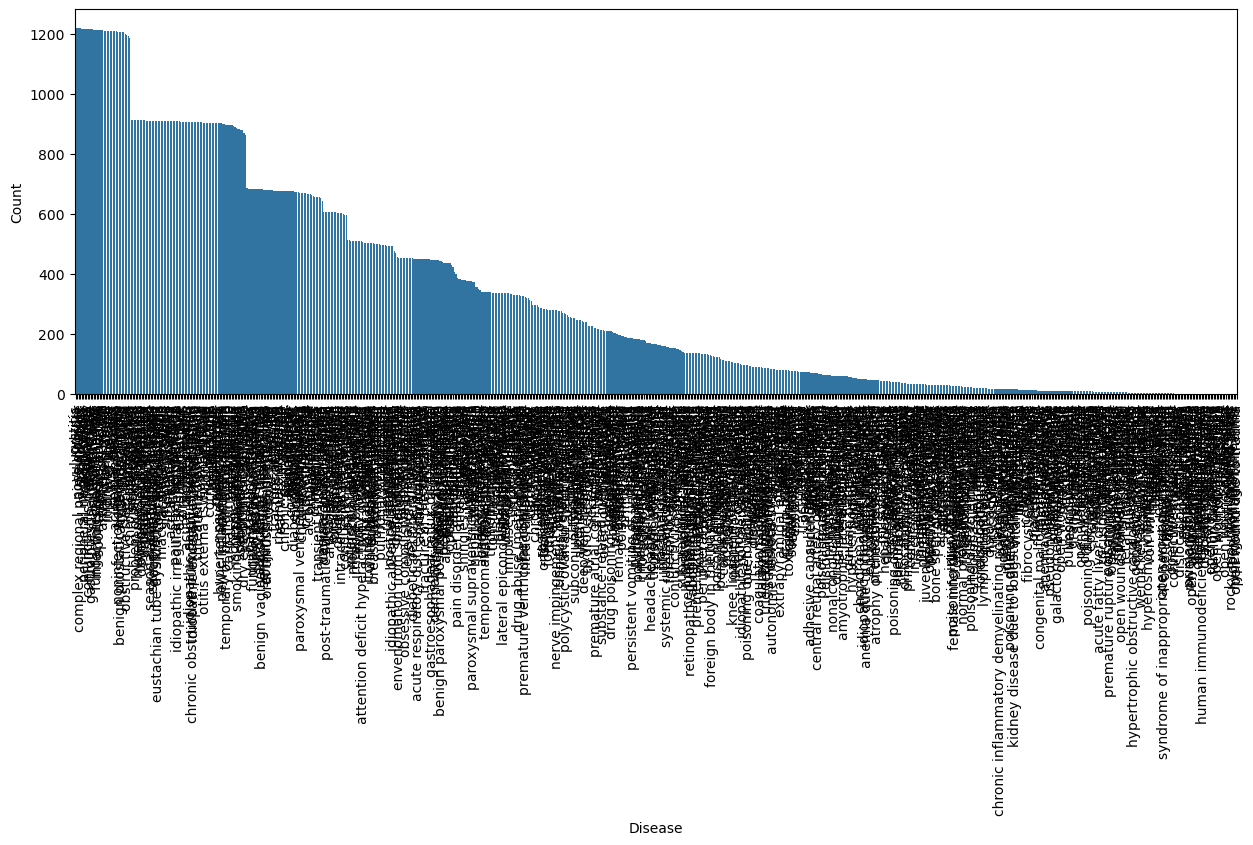

In [29]:
#checking the data
class_count = training_data['diseases'].value_counts()
print(f"the number of disease: {len(class_count)}")
count_df = pd.DataFrame({"Disease": class_count.index, "Count": class_count.values})
plt.figure(figsize=(15, 5))
sns.barplot(x="Disease", y="Count", data=count_df)
plt.xticks(rotation=90)
plt.show()

In [8]:
# Encode the label
# label_encoder = LabelEncoder()
# onehot_encoder = OneHotEncoder()
# training_data['diseases'] = onehot_encoder.fit_transform([training_data['diseases'])

# training_data = pd.get_dummies(training_data['diseases'])

In [30]:
# duplicate samples with the class that has the least number of samples
max_class = class_count.max()
for disease in class_count.index:
    if class_count[disease] < max_class:
        # new samples random drop a value 1 to 0
        new_samples = training_data[training_data['diseases'] == disease].sample(n=max_class - class_count[disease], replace=True)
        num_to_flip = random.randint(1, 6)
        ones_indices = np.argwhere(new_samples.values == 1)
        indices_to_flip = ones_indices[np.random.choice(ones_indices.shape[0], size=num_to_flip, replace=False)]
        for index in indices_to_flip:
            new_samples.iat[index[0], index[1]] = 0
        training_data = pd.concat([training_data, new_samples])

In [26]:
# split the data
X = training_data.drop(columns=['diseases'])
y = training_data['diseases']
while True:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # check if the split is good
    if len(set(y_train)) == 773 and len(set(y_test)) == 773:
        break
print("X_train shape: ", X_train.shape) 
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [19]:
y_train_ohe = pd.get_dummies(y_train)
y_test_ohe = pd.get_dummies(y_test)

In [22]:
np.shape(y_train_ohe)
np.shape(y_test_ohe)

(197556, 766)

In [ ]:
# Defining scoring metric for k-fold cross validation 
def cv_scoring(estimator, X, y): 
	return accuracy_score(y, estimator.predict(X)) 

# Initializing Models 
models = { 
	"SVC":SVC(), 
	"Gaussian NB":GaussianNB(), 
	"Random Forest":RandomForestClassifier(random_state=18) 
} 

# Producing cross validation score for the models 
for model_name in models: 
	model = models[model_name] 
	scores = cross_val_score(model, X, y, cv = 10, 
							n_jobs = -1, 
							scoring = cv_scoring) 
	print("=="*30) 
	print(model_name) 
	print(f"Scores: {scores}") 
	print(f"Mean Score: {np.mean(scores)}")


In [ ]:
model_svc = SVC(probability=True)
model_svc.fit(X_train, y_train)

y_pred = model_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

y_pred_proba = model_svc.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)

print(y_pred_proba[:5])
print(y_pred_proba_max[:5])

In [ ]:
model_rf = RandomForestClassifier(random_state=18)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

y_pred_proba = model_rf.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)

print(y_pred_proba[:5])
print(y_pred_proba_max[:5])

In [ ]:
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train)

y_pred = model_gaussian.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

y_pred_proba = model_gaussian.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)

print(y_pred_proba[:5])
print(y_pred_proba_max[:5])

In [9]:
# ANN model classification with pytorch

# Convert data to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# Define the model
class ANN(torch.nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 2048)
        self.fc2 = torch.nn.Linear(2048, 4096)
        self.fc3 = torch.nn.Linear(4096, 2048)
        self.fc4 = torch.nn.Linear(2048,1024)
        self.fc5 = torch.nn.Linear(1024, len(label_encoder.classes_))
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
model_ann = ANN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.001)

# Train the model using gpu, with validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ann.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
current_val_loss = 10
current_val_accuracy = 0
for epoch in range(200):
    model_ann.train()
    optimizer.zero_grad()
    y_pred = model_ann(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    accuracy = (y_train_tensor == torch.argmax(y_pred, 1)
                ).sum().item() / y_train_tensor.size(0)
    loss.backward()
    optimizer.step()
    model_ann.eval()
    y_pred = model_ann(X_test_tensor)
    val_loss = criterion(y_pred, y_test_tensor)
    val_accuracy = (y_test_tensor == torch.argmax(y_pred, 1)
                    ).sum().item() / y_test_tensor.size(0)
    if (val_loss < current_val_loss and val_accuracy > current_val_accuracy):
        print(f"loss: {current_val_loss} to {val_loss}")
        print(f"accuracy: {current_val_accuracy} to {val_accuracy}")
        current_val_loss = val_loss
        current_val_accuracy = val_accuracy
        torch.save(model_ann.state_dict(), '../model/model_ann.pth')
    print(
        f"Epoch: {epoch}, Loss: {loss.item()}, Acc: {accuracy}, Val_Loss: {val_loss.item()}, Val_Acc: {val_accuracy}")







In [ ]:
# Evaluate the model
model = model_ann
model.load_state_dict(torch.load('../model/model_ann.pth'))
model.eval()
y_pred = model(X_test_tensor)
_, predicted = torch.max(y_pred, 1)
accuracy = (y_test_tensor == predicted).sum().item() / y_test_tensor.size(0)
print(f"Accuracy: {accuracy}")

In [ ]:
print(y_pred[1])
print(torch.argmax(y_pred[1]))